In [4]:
from hmmlearn.hmm import GMMHMM, GaussianHMM
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import *
import pymongo
import warnings
warnings.filterwarnings("ignore")
import logging
logging.getLogger().setLevel(logging.ERROR)
from kaki.utils.check_root_base import find_and_add_project_root


In [11]:

client = pymongo.MongoClient('mongodb://10.201.8.134/')
df = pd.DataFrame(list(client['crypto_db']['BTC-USDT-SWAP-1D'].find()))
print(df)
print(find_and_add_project_root())
df.to_csv(f'{find_and_add_project_root()}/web/assets/btc_data.csv')

def reverse_csv(input_file, output_file):
    pd.read_csv(input_file)[::-1].to_csv(output_file, index=False)

# Example usage
reverse_csv(f"{find_and_add_project_root()}/web/assets/btc_data.csv",f"{find_and_add_project_root()}/web/assets/rev.csv")

                          _id           timestamp     open     high      low  \
0    65c44378de08d397f445dac6 2024-01-31 16:00:00  43362.0  43767.3  41880.0   
1    65c44378de08d397f445dac7 2024-01-30 16:00:00  43383.2  43775.0  42358.1   
2    65c44378de08d397f445dac8 2024-01-29 16:00:00  42649.8  43908.5  42518.7   
3    65c44378de08d397f445dac9 2024-01-28 16:00:00  42264.6  42656.2  41615.0   
4    65c44378de08d397f445daca 2024-01-27 16:00:00  41819.9  42849.6  41727.2   
..                        ...                 ...      ...      ...      ...   
487  65c44379de08d397f445dcad 2022-10-01 16:00:00  19330.0  19399.0  19027.6   
488  65c44379de08d397f445dcae 2022-09-30 16:00:00  19757.4  19869.0  19156.0   
489  65c44379de08d397f445dcaf 2022-09-29 16:00:00  19290.0  20178.6  19117.6   
490  65c44379de08d397f445dcb0 2022-09-28 16:00:00  19490.0  19787.8  18842.8   
491  65c44379de08d397f445dcb1 2022-09-27 16:00:00  19892.1  19955.7  18433.0   

       close    volume     volCcy   vol

### 1 基础数据获取

In [13]:
csv_file = f"{find_and_add_project_root()}/web/assets/rev.csv"
csv_data = pd.read_csv(csv_file)  # 防止弹出警告
df = pd.DataFrame(csv_data)
index_ret = df['close'].pct_change()
df.head()

,Unnamed: 0,_id,timestamp,open,high,low,close,volume,volCcy,volCcyQuote,confirm,Date
0,491,65c44379de08d397f445dcb1,2022-09-27 16:00:00,19892.1,19955.7,18433.0,19490.7,29217398,292173.98,5.561368e+09,1,20220927160000
1,490,65c44379de08d397f445dcb0,2022-09-28 16:00:00,19490.0,19787.8,18842.8,19290.0,20991615,209916.15,4.064287e+09,1,20220928160000
2,489,65c44379de08d397f445dcaf,2022-09-29 16:00:00,19290.0,20178.6,19117.6,19757.1,21863438,218634.38,4.271990e+09,1,20220929160000
3,488,65c44379de08d397f445dcae,2022-09-30 16:00:00,19757.4,19869.0,19156.0,19329.9,11916457,119164.57,2.321717e+09,1,20220930160000
4,487,65c44379de08d397f445dcad,2022-10-01 16:00:00,19330.0,19399.0,19027.6,19146.5,6662954,66629.54,1.281251e+09,1,20221001160000


### 2 特征构建

In [14]:
train = df.loc['2023-01-01':]
test = df.loc[:'2023-01-01']
train['mtm1'] = train['close'].pct_change()
train['mtm5'] = train['close'].pct_change(5)
train['diffreturn'] = (train['high'] - train['low'])/train['low']

train = train.dropna()
closeidx = train['close']
datelist = pd.to_datetime(train.index)
train_X = np.array(train[['mtm1','mtm5','diffreturn']])

### 3 隐马尔科夫模型
#### 3.1 模型训练

In [15]:
hmm = GaussianHMM(n_components=4, covariance_type='diag', n_iter=10000,random_state = 11).fit(train_X)
latent_states_sequence = hmm.predict(train_X)

#### 3.2 训练分类结果

类型0数量：50
类型1数量：208
类型2数量：26
类型3数量：0


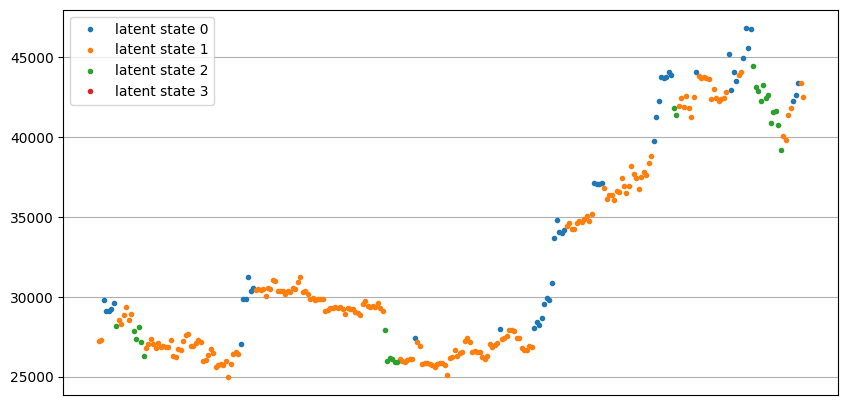

In [16]:
# sns.set_style('white')
plt.figure(figsize=(10, 5))

for i in range(hmm.n_components):
    state = (latent_states_sequence == i)
    print(f'类型{i}数量：{len(datelist[state])}')
    # 作图
    plt.plot(datelist[state],                      # x坐标
             closeidx[state],                      # y坐标
             '.',                                  # 画图样式
             label=f'latent state {i}',          # 图示
              )
    plt.legend()
    plt.grid(1)

data = pd.DataFrame({
    'datelist': datelist,
    'mtm1': train['mtm1'],
    'state': latent_states_sequence
}).set_index('datelist')
plt.savefig("../web/assets/training_result.jpg") ## 保存图片
plt.show()



#### 3.3 收益分组

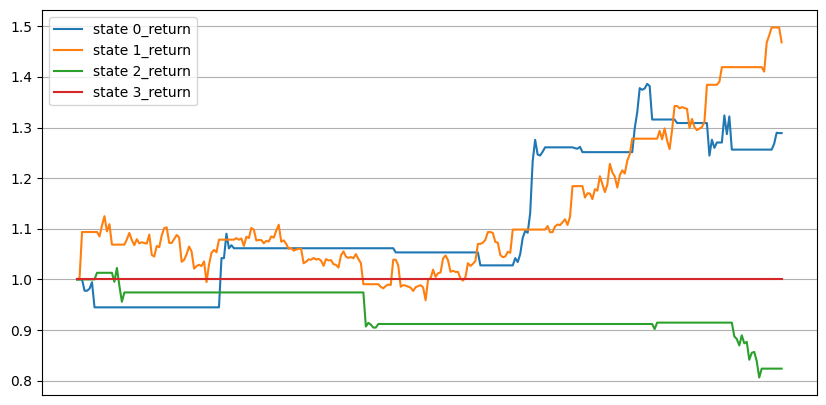

,mtm1,state,state 0_return,state 1_return,state 2_return,state 3_return
datelist,,,,,,
1970-01-01 00:00:00.000000208,-0.007614,1,-0.000000,-0.000000,-0.0,-0.0
1970-01-01 00:00:00.000000209,0.002765,1,0.000000,0.002765,0.0,0.0
1970-01-01 00:00:00.000000210,0.090621,0,0.000000,0.090621,0.0,0.0
1970-01-01 00:00:00.000000211,-0.022410,0,-0.022410,-0.000000,-0.0,-0.0
1970-01-01 00:00:00.000000212,0.000021,0,0.000021,0.000000,0.0,0.0
...,...,...,...,...,...,...
1970-01-01 00:00:00.000000487,0.010629,0,0.000000,0.010629,0.0,0.0
1970-01-01 00:00:00.000000488,0.009119,0,0.009119,0.000000,0.0,0.0
1970-01-01 00:00:00.000000489,0.017193,0,0.017193,0.000000,0.0,0.0


In [17]:
plt.figure(figsize=(10, 5))
for i in range(hmm.n_components):
    name = f'state {i}_return'
    state = (latent_states_sequence == i)
    idx = np.append(0, state[:-1])                         # 当日信号 次日获取收益
    data[name] = data.mtm1.multiply(idx, axis=0)      # 收益计入对应信号中去
    plt.plot((data[name]+1).cumprod(),                     # 计算累计收益
             label=name)
    plt.legend()
    plt.grid(1)
plt.savefig("../web/assets/profit_classification_result.jpg") ## 保存图片
plt.show()
data

#### 3.4 参数遍历

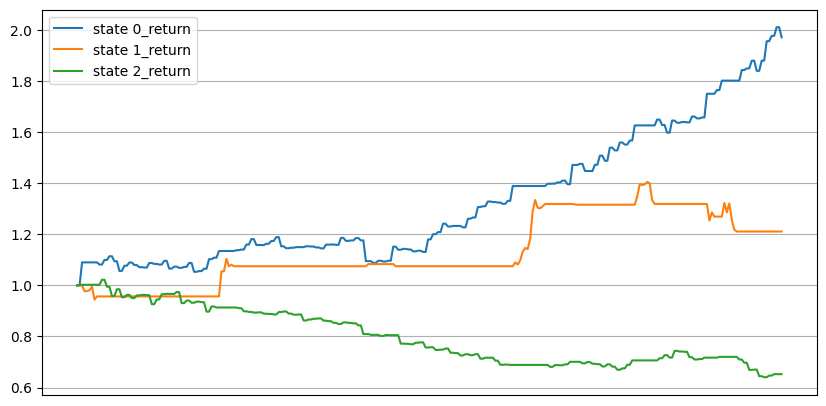

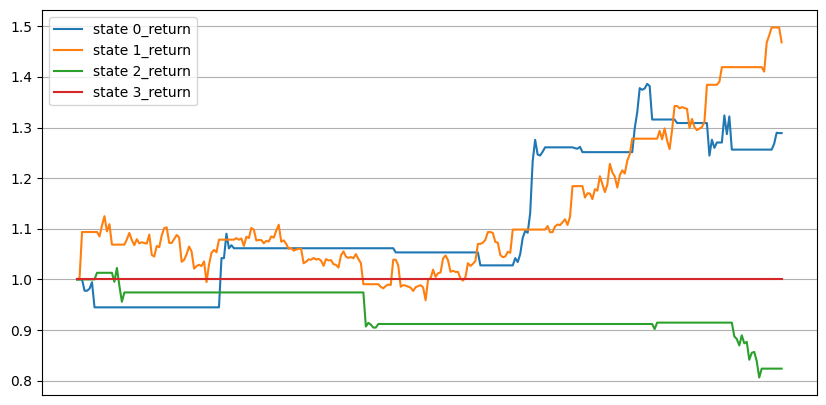

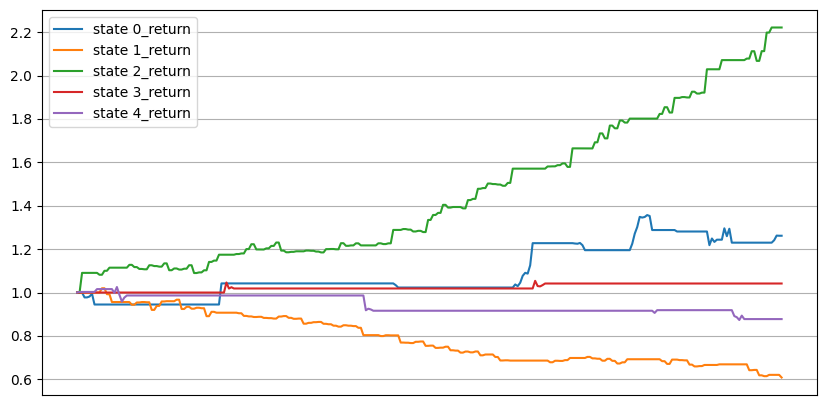

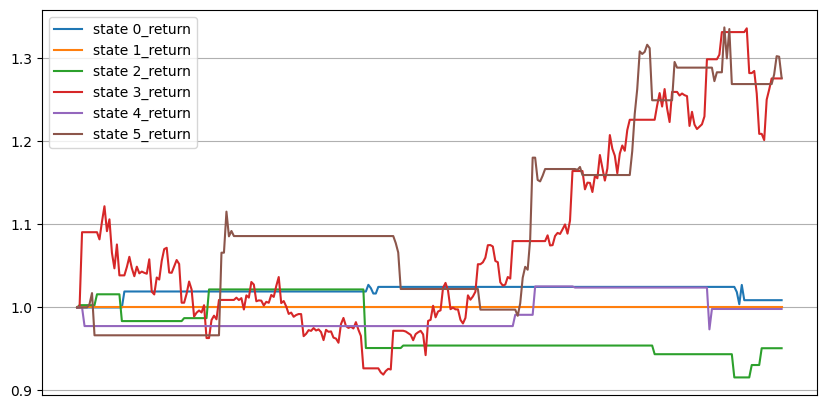

ValueError: transmat_ rows must sum to 1 (got row sums of [1. 1. 0. 1. 1. 1. 1.])

In [18]:
for n_components in range(3,8):
    hmm = GaussianHMM(n_components=n_components, covariance_type='diag', n_iter=10000,random_state = 11).fit(train_X)
    latent_states_sequence = hmm.predict(train_X)
    plt.figure(figsize=(10, 5))
    for i in range(hmm.n_components):
        name = f'state {i}_return'
        state = (latent_states_sequence == i)
        idx = np.append(0, state[:-1])                         # 当日信号 次日获取收益
        data[name] = data.mtm1.multiply(idx, axis=0)      # 收益计入对应信号中去
        plt.plot((data[name]+1).cumprod(),                     # 计算累计收益
                label=name)
        plt.legend()
        plt.grid(1)
        add = "../web/assets/parameters"+str(i-1)+".jpg"
    plt.savefig(add) ## 保存图片
    plt.show()

#### 3.5 目标函数设定：如何定义什么叫做好的分类

In [19]:
cumnet = (data.drop(['mtm1','state'],axis = 1) + 1).cumprod()
cumnet

,state 0_return,state 1_return,state 2_return,state 3_return,state 4_return,state 5_return
datelist,,,,,,
1970-01-01 00:00:00.000000208,1.000000,1.0,1.000000,1.000000,1.000000,1.000000
1970-01-01 00:00:00.000000209,1.000000,1.0,1.002765,1.000000,1.000000,1.000000
1970-01-01 00:00:00.000000210,1.000000,1.0,1.002765,1.090621,1.000000,1.000000
1970-01-01 00:00:00.000000211,1.000000,1.0,1.002765,1.090621,0.977590,1.000000
1970-01-01 00:00:00.000000212,1.000000,1.0,1.002765,1.090621,0.977590,1.000021
...,...,...,...,...,...,...
1970-01-01 00:00:00.000000487,1.008758,1.0,0.950905,1.275782,0.998177,1.269016
1970-01-01 00:00:00.000000488,1.008758,1.0,0.950905,1.275782,0.998177,1.280588
1970-01-01 00:00:00.000000489,1.008758,1.0,0.950905,1.275782,0.998177,1.302606


##### 3.5.1 夏普加权计算

In [20]:
# 夏普计算
def get_sharpe(x):
    # 输入累计收益序列
    final_ret = x.iloc[-1]
    ret = x.pct_change().replace(0,np.nan).dropna()                       # 剔除不变化的天数
    annual_ret = final_ret ** (252/len(ret)) - 1
    std_ret = ret.std()            
    sharpe = abs(annual_ret/std_ret)                    # 绝对值                

    return sharpe

cumnet.apply(lambda x: get_sharpe(x))

ZeroDivisionError: division by zero

In [21]:
fitness_result = {}
for n_components in range(3,8):
    print(n_components)
    hmm = GaussianHMM(n_components=n_components, covariance_type='diag', n_iter=10000,random_state = 11).fit(train_X)
    latent_states_sequence = hmm.predict(train_X)
    data = pd.DataFrame({
                            'datelist': datelist,
                            'mtm1': train['mtm1'],
                            'state': latent_states_sequence
                            }).set_index('datelist')
    
    for i in range(hmm.n_components):
        name = f'state {i}_return'
        state = (latent_states_sequence == i)
        idx = np.append(0, state[:-1])                         # 当日信号 次日获取收益
        data[name] = data.mtm1.multiply(idx, axis=0)      # 收益计入对应信号中去
    cumnet = (data.drop(['mtm1','state'],axis = 1) + 1).cumprod()
    fitness = cumnet.apply(lambda x: get_sharpe(x))
    print(fitness)
    fitness_result[n_components] = round(fitness.mean(),4)

3
state 0_return    156.438683
state 1_return     60.167121
state 2_return     39.283144
dtype: float64
4


ZeroDivisionError: division by zero

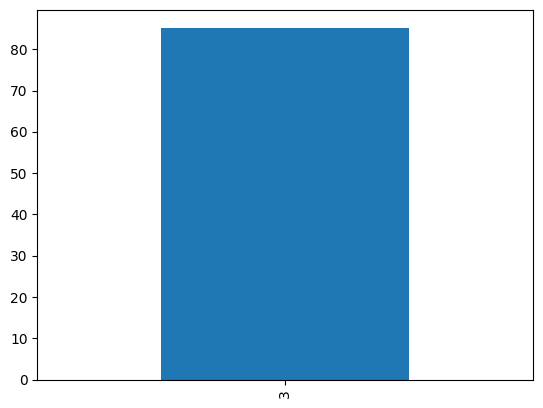

In [22]:
ax = pd.Series(fitness_result).plot(kind = 'bar')
fig=ax.get_figure()
fig.savefig('../web/assets/sharpratio_result.jpg')
# plt.savefig("./front/assets/training_result.jpg") ## 保存图片
# plt.show()

##### 3.5.2 夏普样本加权计算

In [23]:
# 夏普样本加权计算
def get_sharpe_weight(x):
    # 输入累计收益序列
    final_ret = x.iloc[-1]
    ret = x.pct_change().replace(0,np.nan).dropna()                       # 剔除不变化的天数
    annual_ret = final_ret ** (252/len(ret)) - 1
    std_ret = ret.std()            
    sharpe = abs(annual_ret/std_ret)                    # 绝对值  
    sharpe = sharpe * len(ret) / len(x)                 # 数据量修正

    return sharpe

cumnet.apply(lambda x: get_sharpe_weight(x))

ZeroDivisionError: division by zero

In [24]:
fitness_result = {}
for n_components in range(3,8):
    print(n_components)
    hmm = GaussianHMM(n_components=n_components, covariance_type='diag', n_iter=10000,random_state = 11).fit(train_X)
    latent_states_sequence = hmm.predict(train_X)
    data = pd.DataFrame({
                            'datelist': datelist,
                            'mtm1': train['mtm1'],
                            'state': latent_states_sequence
                            }).set_index('datelist')
    
    for i in range(hmm.n_components):
        name = f'state {i}_return'
        state = (latent_states_sequence == i)
        idx = np.append(0, state[:-1])                         # 当日信号 次日获取收益
        data[name] = data.mtm1.multiply(idx, axis=0)      # 收益计入对应信号中去
    cumnet = (data.drop(['mtm1','state'],axis = 1) + 1).cumprod()
    fitness = cumnet.apply(lambda x: get_sharpe_weight(x))
    print(fitness)
    fitness_result[n_components] = round(fitness.mean(),4)

3
state 0_return    67.202533
state 1_return     9.745379
state 2_return    15.906907
dtype: float64
4


ZeroDivisionError: division by zero

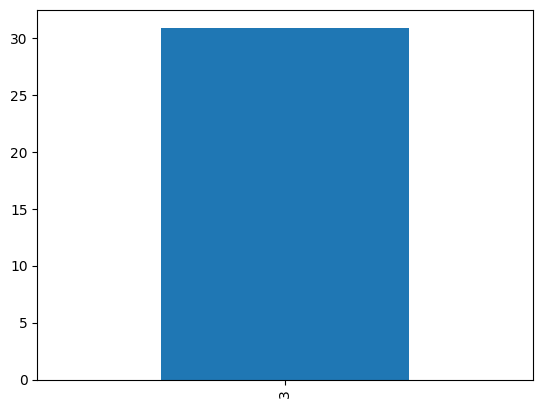

In [25]:
ax=pd.Series(fitness_result).plot(kind = 'bar')
fig=ax.get_figure()
fig.savefig('../web/assets/Sharpe_Sample_Weighted_Calculation_result.jpg')

In [26]:
pd.Series(fitness_result).sort_values().index[-1]

3

#### 3.6 选入最优的参数

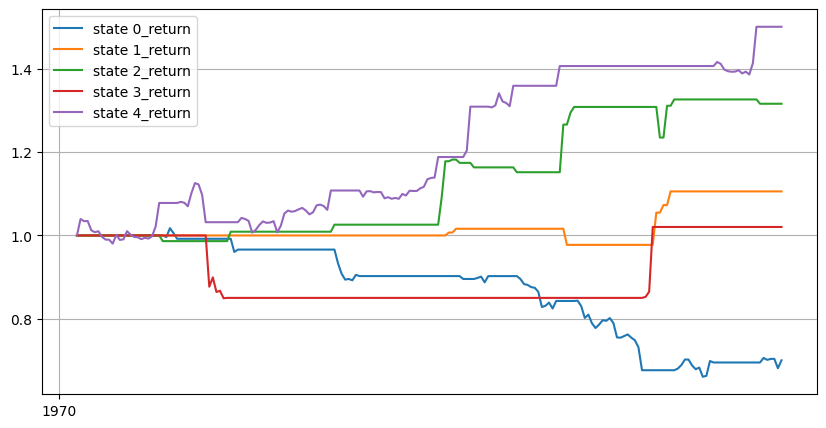

,mtm1,state,state 0_return,state 1_return,state 2_return,state 3_return,state 4_return
datelist,,,,,,,
1970-01-01 00:00:00.000000005,0.009997,4,0.000000,0.0,0.0,0.0,0.000000
1970-01-01 00:00:00.000000006,0.039358,4,0.000000,0.0,0.0,0.0,0.039358
1970-01-01 00:00:00.000000007,-0.004970,4,-0.000000,-0.0,-0.0,-0.0,-0.004970
1970-01-01 00:00:00.000000008,0.000545,4,0.000000,0.0,0.0,0.0,0.000545
1970-01-01 00:00:00.000000009,-0.021494,4,-0.000000,-0.0,-0.0,-0.0,-0.021494
...,...,...,...,...,...,...,...
1970-01-01 00:00:00.000000198,-0.006565,0,-0.006565,-0.0,-0.0,-0.0,-0.000000
1970-01-01 00:00:00.000000199,0.003278,0,0.003278,0.0,0.0,0.0,0.000000
1970-01-01 00:00:00.000000200,0.000086,0,0.000086,0.0,0.0,0.0,0.000000


In [27]:
train = df.loc[:'2023-01-01']

train['mtm1'] = train['close'].pct_change()
train['mtm5'] = train['close'].pct_change(5)
train['diffreturn'] = (train['high'] - train['low'])/train['low']

train = train.dropna()
closeidx = train['close']
datelist = pd.to_datetime(train.index)
train_X = np.array(train[['mtm1','mtm5','diffreturn']])

hmm = GaussianHMM(n_components=5, covariance_type='diag', n_iter=10000,random_state = 11).fit(train_X)
latent_states_sequence = hmm.predict(train_X)

data = pd.DataFrame({
    'datelist': datelist,
    'mtm1': train['mtm1'],
    'state': latent_states_sequence
}).set_index('datelist')

plt.figure(figsize=(10, 5))
for i in range(hmm.n_components):
    name = f'state {i}_return'
    state = (latent_states_sequence == i)
    idx = np.append(0, state[:-1])                         # 当日信号 次日获取收益
    data[name] = data.mtm1.multiply(idx, axis=0)      # 收益计入对应信号中去
    plt.plot((data[name]+1).cumprod(),                     # 计算累计收益
             label=name)
    plt.legend()
    plt.grid(1)
plt.savefig("../web/assets/best_param.jpg") ## 保存图片
plt.show()

data

策略: 清仓1、4信号，保留2，3信号 ，半仓0信号

### 4 样本外训练

In [28]:
test = df.loc['2023-01-01':]

test['mtm1'] = test['close'].pct_change()
test['mtm5'] = test['close'].pct_change(5)
test['diffreturn'] = (test['high'] - test['low'])/test['low']

test = test.dropna()
closeidx = test['close']
datelist = pd.to_datetime(test.index)
test_X = np.array(test[['mtm1','mtm5','diffreturn']])

In [29]:
latent_states_sequence = hmm.predict(test_X)
latent_states_sequence

array([4, 4, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 1, 2, 1, 2, 0, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 3, 3, 2, 0, 0, 0, 4, 4, 4, 4, 4, 4, 2, 0, 0, 0, 0,
       0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2,
       0, 0, 0, 0, 0, 4, 2, 1, 2, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 2, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 1, 2, 0, 4, 4, 4, 2, 1, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

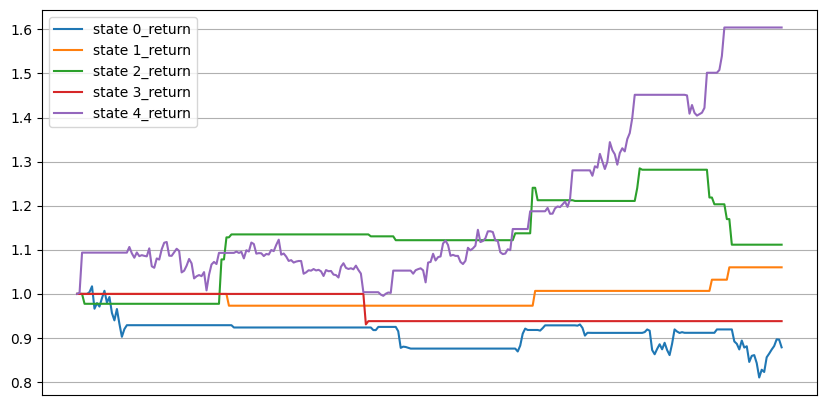

,mtm1,state,state 0_return,state 1_return,state 2_return,state 3_return,state 4_return
datelist,,,,,,,
1970-01-01 00:00:00.000000208,-0.007614,4,-0.000000,-0.0,-0.000000,-0.0,-0.000000
1970-01-01 00:00:00.000000209,0.002765,4,0.000000,0.0,0.000000,0.0,0.002765
1970-01-01 00:00:00.000000210,0.090621,2,0.000000,0.0,0.000000,0.0,0.090621
1970-01-01 00:00:00.000000211,-0.022410,2,-0.000000,-0.0,-0.022410,-0.0,-0.000000
1970-01-01 00:00:00.000000212,0.000021,0,0.000000,0.0,0.000021,0.0,0.000000
...,...,...,...,...,...,...,...
1970-01-01 00:00:00.000000487,0.010629,0,0.010629,0.0,0.000000,0.0,0.000000
1970-01-01 00:00:00.000000488,0.009119,0,0.009119,0.0,0.000000,0.0,0.000000
1970-01-01 00:00:00.000000489,0.017193,0,0.017193,0.0,0.000000,0.0,0.000000


In [30]:
data = pd.DataFrame({
    'datelist': datelist,
    'mtm1': test['mtm1'],
    'state': latent_states_sequence
}).set_index('datelist')

plt.figure(figsize=(10, 5))
for i in range(hmm.n_components):
    name = f'state {i}_return'
    state = (latent_states_sequence == i)
    idx = np.append(0, state[:-1])                         # 当日信号 次日获取收益
    data[name] = data.mtm1.multiply(idx, axis=0)      # 收益计入对应信号中去
    plt.plot((data[name]+1).cumprod(),                     # 计算累计收益
             label=name)
    plt.legend()
    plt.grid(1)
plt.savefig("../web/assets/training_outside.jpg") ## 保存图片
plt.show()
data

In [31]:
strategy = (
            data['state 0_return'] * 0.5
            + data['state 1_return'] * 0
            + data['state 2_return'] * 1
            + data['state 3_return'] * 1
            + data['state 4_return'] * 0
            )

                               strategy
datelist                               
1970-01-01 00:00:00.000000208 -0.000000
1970-01-01 00:00:00.000000209  0.000000
1970-01-01 00:00:00.000000210  0.000000
1970-01-01 00:00:00.000000211 -0.022410
1970-01-01 00:00:00.000000212  0.000021
...                                 ...
1970-01-01 00:00:00.000000487  0.005314
1970-01-01 00:00:00.000000488  0.004559
1970-01-01 00:00:00.000000489  0.008597
1970-01-01 00:00:00.000000490 -0.000243
1970-01-01 00:00:00.000000491 -0.009800

[284 rows x 1 columns]
     benchmark
208  -0.007614
209   0.002765
210   0.090621
211  -0.022410
212   0.000021
..         ...
487   0.010629
488   0.009119
489   0.017193
490  -0.000486
491  -0.019600

[284 rows x 1 columns]


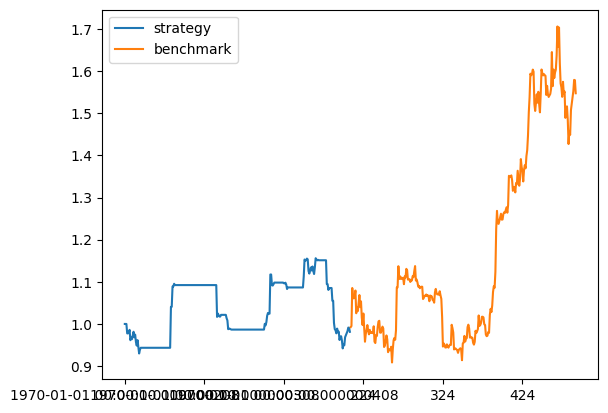

In [32]:
net = pd.concat([strategy.to_frame('strategy'),test['mtm1'].to_frame('benchmark')],axis = 1)
print(strategy.to_frame('strategy'))
print(test['mtm1'].to_frame('benchmark'))
cumnet = (1 + net).cumprod()
ax = cumnet.plot()
fig=ax.get_figure()
fig.savefig('../web/assets/predict.jpg')
# fig.savefig('../front/pages/1.png')


### 5 滚动训练

In [33]:
csv_file = "rev.csv"
csv_data = pd.read_csv(csv_file)  # 防止弹出警告
df = pd.DataFrame(csv_data)
index_ret = df['close'].pct_change()

df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'rev.csv'

In [34]:
r = 1.0
hist_len = 200
retrain_gap = 60
data_trade = []
length = df.shape[0]

# 夏普样本加权计算
def get_sharpe_weight(x):
    # 输入累计收益序列
    try:                                                                      # 防止进来的就没有数据
        final_ret = x.iloc[-1]
        ret = x.pct_change().replace(0,np.nan).dropna()                       # 剔除不变化的天数
        annual_ret = final_ret ** (252/len(ret)) - 1
        std_ret = ret.std()            
        sharpe = abs(annual_ret/std_ret)                                      # 绝对值  
        sharpe = sharpe * len(ret) / len(x)                                   # 数据量修正
    except:
        sharpe = 0

    return sharpe

def get_param(train,train_X,datelist):
    fitness_result = {}
    for n_components in range(3,8):
        try:
            hmm = GaussianHMM(n_components=n_components, covariance_type='diag', n_iter=10000,random_state = 11).fit(train_X)
            latent_states_sequence = hmm.predict(train_X)
            data = pd.DataFrame({
                                    'datelist': datelist,
                                    'mtm1': train['mtm1'],
                                    'state': latent_states_sequence
                                    }).set_index('datelist')
            
            for i in range(hmm.n_components):
                name = f'state {i}_return'
                state = (latent_states_sequence == i)
                idx = np.append(0, state[:-1])                         # 当日信号 次日获取收益
                data[name] = data.mtm1.multiply(idx, axis=0)           # 收益计入对应信号中去
            cumnet = (data.drop(['mtm1','state'],axis = 1) + 1).cumprod()
            fitness = cumnet.apply(lambda x: get_sharpe_weight(x))
            fitness_result[n_components] = round(fitness.mean(),4)
        except:
            continue
    best_n_components = pd.Series(fitness_result).sort_values().index[-1]

    return best_n_components


def get_signal_return(latent_states_sequence,train,datelist):
    data = pd.DataFrame({
        'datelist': datelist,
        'mtm1': train['mtm1'],
        'state': latent_states_sequence
    }).set_index('datelist')

    for i in range(hmm.n_components):
        name = f'state {i}_return'
        state = (latent_states_sequence == i)
        idx = np.append(0, state[:-1])                         # 当日信号 次日获取收益
        data[name] = data.mtm1.multiply(idx, axis=0)           # 收益计入对应信号中去
    
    return data

for i in tqdm(range(hist_len,length,retrain_gap)):

    # 1. 训练集特征构建
    train = df.iloc[i-hist_len:i]
    train['mtm1'] = train['close'].pct_change()
    train['mtm5'] = train['close'].pct_change(5)
    train['diffreturn'] = (train['high'] - train['low'])/train['low']
    train['volume_z'] = (train['volume'] - train['volume'].rolling(20).mean())/train['volume'].rolling(20).std()
    train = train.dropna()
    closeidx = train['mtm1']
    train_X = np.array(train[['mtm5','diffreturn','volume_z']])
    datelist = pd.to_datetime(train.index)

    # 2. 训练集参数遍历
    best_n_components = get_param(train,train_X,datelist)
    
    # 3. 训练集内放入最优参数
    
    hmm = GaussianHMM(n_components = best_n_components, covariance_type='diag', n_iter=10000,random_state = 11).fit(train_X)
    latent_states_sequence = hmm.predict(train_X)

    data = get_signal_return(latent_states_sequence,train,datelist)

    # 4. 选择清仓的信号
    cumnet = (data.drop(['mtm1','state'],axis = 1) + 1).cumprod()
    get_signal = (cumnet.iloc[-1] < r).replace(False,np.nan).dropna().index.tolist()
    get_signal = [int(i[6:7]) for i in get_signal]                     # 转成数字形式

    # 5. 样本外计算
    test = df.iloc[i - hist_len: i + retrain_gap - 1]       # 因为有预计算所以先长的算完，再切分 （往前20天也够了）
    test['mtm1'] = test['close'].pct_change()
    test['mtm5'] = test['close'].pct_change(5)
    test['diffreturn'] = (test['high'] - test['low'])/test['low']
    test['volume_z'] = (test['volume'] - test['volume'].rolling(20).mean())/test['volume'].rolling(20).std()
    test = test.dropna()
    test = test.iloc[-(retrain_gap - 1):]
    closeidx = test['mtm1']
    test_X = np.array(test[['mtm5','diffreturn','volume_z']])
    
    datelist = test.index
    print(datelist)
    
    latent_states_sequence = hmm.predict(test_X)

    data = pd.DataFrame({
            'datelist': datelist,
            'mtm1': test['mtm1'],
            'state': latent_states_sequence
        }).set_index('datelist')
    
    # 6. 清仓信号叠加
    data_trade += data[data.state.isin(get_signal)].index.tolist()

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.17it/s]

Index([200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213,
       214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227,
       228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241,
       242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255,
       256, 257, 258],
      dtype='int64')
Index([260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273,
       274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287,
       288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301,
       302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315,
       316, 317, 318],
      dtype='int64')


 80%|████████  | 4/5 [00:00<00:00,  5.96it/s]

Index([320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333,
       334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347,
       348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361,
       362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375,
       376, 377, 378],
      dtype='int64')
Index([380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393,
       394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407,
       408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421,
       422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435,
       436, 437, 438],
      dtype='int64')


100%|██████████| 5/5 [00:00<00:00,  5.47it/s]

Index([433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446,
       447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460,
       461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474,
       475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488,
       489, 490, 491],
      dtype='int64')


#### 5.1 收益计算

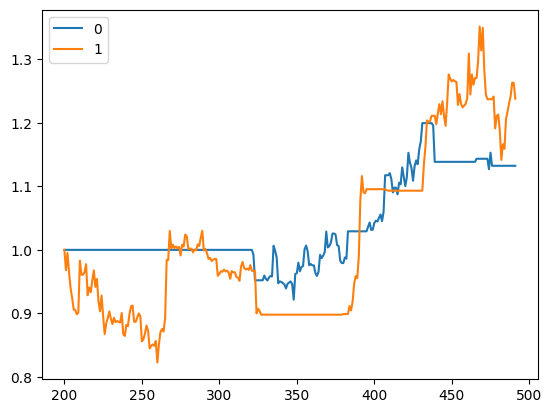

In [35]:
net = index_ret.to_frame('ret').iloc[hist_len:]

net.loc[data_trade,'clear_day'] = 0           # 加上清仓信号
net = net.fillna(1)

for i in [0,1]:
    name = i
    state = net.clear_day == i
    idx = np.append(0, state[:-1])
    net[name] = net.ret.multiply(idx, axis=0)

cumnet = (net.drop(['ret','clear_day'],axis = 1) + 1).cumprod()
ax = cumnet.plot()
cumnet
fig=ax.get_figure()
fig.savefig('../web/assets/profit_calculation.jpg')

#### 5.2 阈值调整

In [36]:
r = 1.1
hist_len = 200
retrain_gap = 60
data_trade = []
length = df.shape[0]

# 夏普样本加权计算
def get_sharpe_weight(x):
    # 输入累计收益序列
    try:                                                                      # 防止进来的就没有数据
        final_ret = x.iloc[-1]
        ret = x.pct_change().replace(0,np.nan).dropna()                       # 剔除不变化的天数
        annual_ret = final_ret ** (252/len(ret)) - 1
        std_ret = ret.std()            
        sharpe = abs(annual_ret/std_ret)                                      # 绝对值  
        sharpe = sharpe * len(ret) / len(x)                                   # 数据量修正
    except:
        sharpe = 0

    return sharpe

def get_param(train,train_X,datelist):
    fitness_result = {}
    for n_components in range(3,8):
        try:
            hmm = GaussianHMM(n_components=n_components, covariance_type='diag', n_iter=10000,random_state = 11).fit(train_X)
            latent_states_sequence = hmm.predict(train_X)
            data = pd.DataFrame({
                                    'datelist': datelist,
                                    'mtm1': train['mtm1'],
                                    'state': latent_states_sequence
                                    }).set_index('datelist')
            
            for i in range(hmm.n_components):
                name = f'state {i}_return'
                state = (latent_states_sequence == i)
                idx = np.append(0, state[:-1])                         # 当日信号 次日获取收益
                data[name] = data.mtm1.multiply(idx, axis=0)           # 收益计入对应信号中去
            cumnet = (data.drop(['mtm1','state'],axis = 1) + 1).cumprod()
            fitness = cumnet.apply(lambda x: get_sharpe_weight(x))
            fitness_result[n_components] = round(fitness.mean(),4)
        except:
            continue
    best_n_components = pd.Series(fitness_result).sort_values().index[-1]

    return best_n_components


def get_signal_return(latent_states_sequence,train,datelist):
    data = pd.DataFrame({
        'datelist': datelist,
        'mtm1': train['mtm1'],
        'state': latent_states_sequence
    }).set_index('datelist')

    for i in range(hmm.n_components):
        name = f'state {i}_return'
        state = (latent_states_sequence == i)
        idx = np.append(0, state[:-1])                         # 当日信号 次日获取收益
        data[name] = data.mtm1.multiply(idx, axis=0)           # 收益计入对应信号中去
    
    return data

for i in tqdm(range(hist_len,length,retrain_gap)):

    # 1. 训练集特征构建
    train = df.iloc[i-hist_len:i]
    train['mtm1'] = train['close'].pct_change()
    train['mtm5'] = train['close'].pct_change(5)
    train['diffreturn'] = (train['high'] - train['low'])/train['low']
    train['volume_z'] = (train['volume'] - train['volume'].rolling(20).mean())/train['volume'].rolling(20).std()
    train = train.dropna()
    closeidx = train['mtm1']
    train_X = np.array(train[['mtm5','diffreturn','volume_z']])
    datelist = pd.to_datetime(train.index)

    # 2. 训练集参数遍历
    best_n_components = get_param(train,train_X,datelist)
    
    # 3. 训练集内放入最优参数
    
    hmm = GaussianHMM(n_components = best_n_components, covariance_type='diag', n_iter=10000,random_state = 11).fit(train_X)
    latent_states_sequence = hmm.predict(train_X)

    data = get_signal_return(latent_states_sequence,train,datelist)

    # 4. 选择清仓的信号
    cumnet = (data.drop(['mtm1','state'],axis = 1) + 1).cumprod()
    get_signal = (cumnet.iloc[-1] < r).replace(False,np.nan).dropna().index.tolist()
    get_signal = [int(i[6:7]) for i in get_signal]                     # 转成数字形式

    # 5. 样本外计算
    test = df.iloc[i - hist_len: i + retrain_gap - 1]       # 因为有预计算所以先长的算完，再切分 （往前20天也够了）
    test['mtm1'] = test['close'].pct_change()
    test['mtm5'] = test['close'].pct_change(5)
    test['diffreturn'] = (test['high'] - test['low'])/test['low']
    test['volume_z'] = (test['volume'] - test['volume'].rolling(20).mean())/test['volume'].rolling(20).std()
    test = test.dropna()
    test = test.iloc[-(retrain_gap - 1):]
    closeidx = test['mtm1']
    test_X = np.array(test[['mtm5','diffreturn','volume_z']])
    datelist = test.index
    
    latent_states_sequence = hmm.predict(test_X)

    data = pd.DataFrame({
            'datelist': datelist,
            'mtm1': test['mtm1'],
            'state': latent_states_sequence
        }).set_index('datelist')
    
    # 6. 清仓信号叠加
    data_trade += data[data.state.isin(get_signal)].index.tolist()

100%|██████████| 5/5 [00:00<00:00,  7.73it/s]


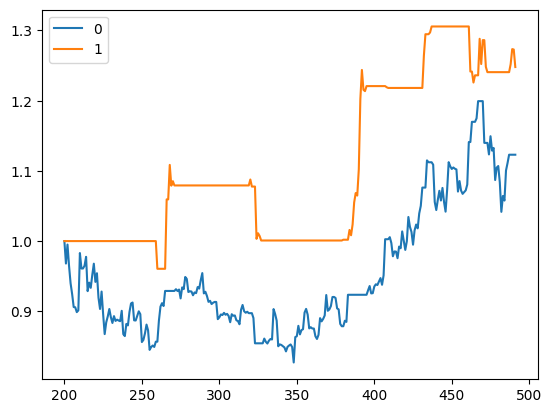

In [37]:

net = index_ret.to_frame('ret').iloc[hist_len:]

net.loc[data_trade,'clear_day'] = 0           # 加上清仓信号
net = net.fillna(1)

for i in [0,1]:
    name = i
    state = net.clear_day == i
    idx = np.append(0, state[:-1])
    net[name] = net.ret.multiply(idx, axis=0)

cumnet = (net.drop(['ret','clear_day'],axis = 1) + 1).cumprod()
ax = cumnet.plot()
cumnet
fig=ax.get_figure()
fig.savefig('../web/assets/threshold_adjustment1.jpg')

In [38]:
r = 0.9
hist_len = 200
retrain_gap = 60
data_trade = []
length = df.shape[0]

# 夏普样本加权计算
def get_sharpe_weight(x):
    # 输入累计收益序列
    try:                                                                      # 防止进来的就没有数据
        final_ret = x.iloc[-1]
        ret = x.pct_change().replace(0,np.nan).dropna()                       # 剔除不变化的天数
        annual_ret = final_ret ** (252/len(ret)) - 1
        std_ret = ret.std()            
        sharpe = abs(annual_ret/std_ret)                                      # 绝对值  
        sharpe = sharpe * len(ret) / len(x)                                   # 数据量修正
    except:
        sharpe = 0

    return sharpe

def get_param(train,train_X,datelist):
    fitness_result = {}
    for n_components in range(3,8):
        try:
            hmm = GaussianHMM(n_components=n_components, covariance_type='diag', n_iter=10000,random_state = 11).fit(train_X)
            latent_states_sequence = hmm.predict(train_X)
            data = pd.DataFrame({
                                    'datelist': datelist,
                                    'mtm1': train['mtm1'],
                                    'state': latent_states_sequence
                                    }).set_index('datelist')
            
            for i in range(hmm.n_components):
                name = f'state {i}_return'
                state = (latent_states_sequence == i)
                idx = np.append(0, state[:-1])                         # 当日信号 次日获取收益
                data[name] = data.mtm1.multiply(idx, axis=0)           # 收益计入对应信号中去
            cumnet = (data.drop(['mtm1','state'],axis = 1) + 1).cumprod()
            fitness = cumnet.apply(lambda x: get_sharpe_weight(x))
            fitness_result[n_components] = round(fitness.mean(),4)
        except:
            continue
    best_n_components = pd.Series(fitness_result).sort_values().index[-1]

    return best_n_components


def get_signal_return(latent_states_sequence,train,datelist):
    data = pd.DataFrame({
        'datelist': datelist,
        'mtm1': train['mtm1'],
        'state': latent_states_sequence
    }).set_index('datelist')

    for i in range(hmm.n_components):
        name = f'state {i}_return'
        state = (latent_states_sequence == i)
        idx = np.append(0, state[:-1])                         # 当日信号 次日获取收益
        data[name] = data.mtm1.multiply(idx, axis=0)           # 收益计入对应信号中去
    
    return data

for i in tqdm(range(hist_len,length,retrain_gap)):

    # 1. 训练集特征构建
    train = df.iloc[i-hist_len:i]
    train['mtm1'] = train['close'].pct_change()
    train['mtm5'] = train['close'].pct_change(5)
    train['diffreturn'] = (train['high'] - train['low'])/train['low']
    train['volume_z'] = (train['volume'] - train['volume'].rolling(20).mean())/train['volume'].rolling(20).std()
    train = train.dropna()
    closeidx = train['mtm1']
    train_X = np.array(train[['mtm5','diffreturn','volume_z']])
    datelist = pd.to_datetime(train.index)

    # 2. 训练集参数遍历
    best_n_components = get_param(train,train_X,datelist)
    
    # 3. 训练集内放入最优参数
    
    hmm = GaussianHMM(n_components = best_n_components, covariance_type='diag', n_iter=10000,random_state = 11).fit(train_X)
    latent_states_sequence = hmm.predict(train_X)

    data = get_signal_return(latent_states_sequence,train,datelist)

    # 4. 选择清仓的信号
    cumnet = (data.drop(['mtm1','state'],axis = 1) + 1).cumprod()
    get_signal = (cumnet.iloc[-1] < r).replace(False,np.nan).dropna().index.tolist()
    get_signal = [int(i[6:7]) for i in get_signal]                     # 转成数字形式

    # 5. 样本外计算
    test = df.iloc[i - hist_len: i + retrain_gap - 1]       # 因为有预计算所以先长的算完，再切分 （往前20天也够了）
    test['mtm1'] = test['close'].pct_change()
    test['mtm5'] = test['close'].pct_change(5)
    test['diffreturn'] = (test['high'] - test['low'])/test['low']
    test['volume_z'] = (test['volume'] - test['volume'].rolling(20).mean())/test['volume'].rolling(20).std()
    test = test.dropna()
    test = test.iloc[-(retrain_gap - 1):]
    closeidx = test['mtm1']
    test_X = np.array(test[['mtm5','diffreturn','volume_z']])
    datelist = test.index
    
    latent_states_sequence = hmm.predict(test_X)

    data = pd.DataFrame({
            'datelist': datelist,
            'mtm1': test['mtm1'],
            'state': latent_states_sequence
        }).set_index('datelist')
    
    # 6. 清仓信号叠加
    data_trade += data[data.state.isin(get_signal)].index.tolist()

100%|██████████| 5/5 [00:00<00:00,  7.65it/s]


True


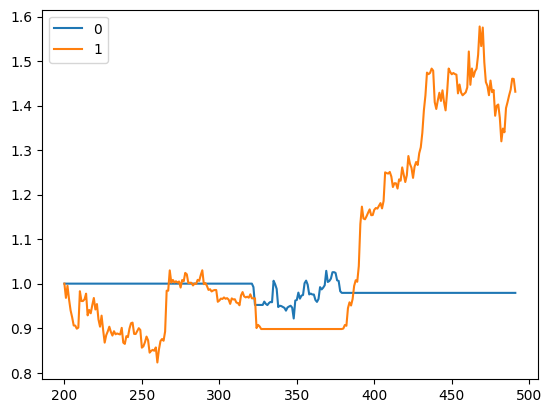

In [39]:
print(len(index_ret.to_frame('ret'))>hist_len)
net = index_ret.to_frame('ret').iloc[hist_len:]
net.loc[data_trade,'clear_day'] = 0           # 加上清仓信号
net = net.fillna(1)

for i in [0,1]:
    name = i
    state = net.clear_day == i
    idx = np.append(0, state[:-1])
    net[name] = net.ret.multiply(idx, axis=0)

cumnet = (net.drop(['ret','clear_day'],axis = 1) + 1).cumprod()
ax = cumnet.plot()
cumnet
fig=ax.get_figure()
fig.savefig('../web/assets/thresh_adj2.jpg')

#### 5.3 动态阈值

In [40]:
hist_len = 200
retrain_gap = 60
data_trade = []
length = df.shape[0]

# 夏普样本加权计算
def get_sharpe_weight(x):
    # 输入累计收益序列
    try:                                                                      # 防止进来的就没有数据
        final_ret = x.iloc[-1]
        ret = x.pct_change().replace(0,np.nan).dropna()                       # 剔除不变化的天数
        annual_ret = final_ret ** (252/len(ret)) - 1
        std_ret = ret.std()            
        sharpe = abs(annual_ret/std_ret)                                      # 绝对值  
        sharpe = sharpe * len(ret) / len(x)                                   # 数据量修正
    except:
        sharpe = 0

    return sharpe

def get_param(train,train_X,datelist):
    fitness_result = {}
    for n_components in range(3,8):
        try:
            hmm = GaussianHMM(n_components=n_components, covariance_type='diag', n_iter=10000,random_state = 11).fit(train_X)
            latent_states_sequence = hmm.predict(train_X)
            data = pd.DataFrame({
                                    'datelist': datelist,
                                    'mtm1': train['mtm1'],
                                    'state': latent_states_sequence
                                    }).set_index('datelist')
            
            for i in range(hmm.n_components):
                name = f'state {i}_return'
                state = (latent_states_sequence == i)
                idx = np.append(0, state[:-1])                         # 当日信号 次日获取收益
                data[name] = data.mtm1.multiply(idx, axis=0)           # 收益计入对应信号中去
            cumnet = (data.drop(['mtm1','state'],axis = 1) + 1).cumprod()
            fitness = cumnet.apply(lambda x: get_sharpe_weight(x))
            fitness_result[n_components] = round(fitness.mean(),4)
        except:
            continue
    best_n_components = pd.Series(fitness_result).sort_values().index[-1]

    return best_n_components


def get_signal_return(latent_states_sequence,train,datelist):
    data = pd.DataFrame({
        'datelist': datelist,
        'mtm1': train['mtm1'],
        'state': latent_states_sequence
    }).set_index('datelist')

    for i in range(hmm.n_components):
        name = f'state {i}_return'
        state = (latent_states_sequence == i)
        idx = np.append(0, state[:-1])                         # 当日信号 次日获取收益
        data[name] = data.mtm1.multiply(idx, axis=0)           # 收益计入对应信号中去
    
    return data

for i in tqdm(range(hist_len,length,retrain_gap)):

    # 1. 训练集特征构建
    train = df.iloc[i-hist_len:i]
    train['mtm1'] = train['close'].pct_change()
    train['mtm5'] = train['close'].pct_change(5)
    train['diffreturn'] = (train['high'] - train['low'])/train['low']
    train['volume_z'] = (train['volume'] - train['volume'].rolling(20).mean())/train['volume'].rolling(20).std()
    train = train.dropna()
    closeidx = train['mtm1']
    train_X = np.array(train[['mtm5','diffreturn','volume_z']])
    datelist = pd.to_datetime(train.index)

    # 2. 训练集参数遍历
    best_n_components = get_param(train,train_X,datelist)
    
    # 3. 训练集内放入最优参数
    
    hmm = GaussianHMM(n_components = best_n_components, covariance_type='diag', n_iter=10000,random_state = 11).fit(train_X)
    latent_states_sequence = hmm.predict(train_X)

    data = get_signal_return(latent_states_sequence,train,datelist)

    # 4. 选择清仓的信号
    cumnet = (data.drop(['mtm1','state'],axis = 1) + 1).cumprod()
    get_signal = (cumnet.iloc[-1] < (data.mtm1 + 1).cumprod().iloc[-1]).replace(False,np.nan).dropna().index.tolist()
    get_signal = [int(i[6:7]) for i in get_signal]                     # 转成数字形式

    # 5. 样本外计算
    test = df.iloc[i - hist_len: i + retrain_gap - 1]       # 因为有预计算所以先长的算完，再切分 （往前20天也够了）
    test['mtm1'] = test['close'].pct_change()
    test['mtm5'] = test['close'].pct_change(5)
    test['diffreturn'] = (test['high'] - test['low'])/test['low']
    test['volume_z'] = (test['volume'] - test['volume'].rolling(20).mean())/test['volume'].rolling(20).std()
    test = test.dropna()
    test = test.iloc[-(retrain_gap - 1):]
    closeidx = test['mtm1']
    test_X = np.array(test[['mtm5','diffreturn','volume_z']])
    datelist = test.index
    
    latent_states_sequence = hmm.predict(test_X)

    data = pd.DataFrame({
            'datelist': datelist,
            'mtm1': test['mtm1'],
            'state': latent_states_sequence
        }).set_index('datelist')
    
    # 6. 清仓信号叠加
    data_trade += data[data.state.isin(get_signal)].index.tolist()

100%|██████████| 5/5 [00:00<00:00,  7.43it/s]


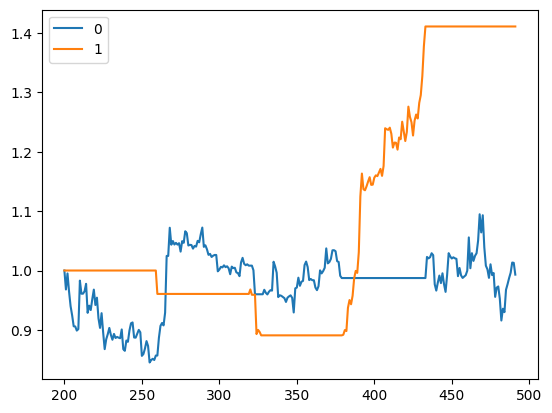

In [41]:
net = index_ret.to_frame('ret').iloc[hist_len:]
net.loc[data_trade,'clear_day'] = 0           # 加上清仓信号
net = net.fillna(1)

for i in [0,1]:
    name = i
    state = net.clear_day == i
    idx = np.append(0, state[:-1])
    net[name] = net.ret.multiply(idx, axis=0)

cumnet = (net.drop(['ret','clear_day'],axis = 1) + 1).cumprod()
ax = cumnet.plot()
cumnet
fig=ax.get_figure()
fig.savefig('../web/assets/dynamic_threshold.jpg')